In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from torchvision import datasets, transforms
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

drive_path = 'drive/My Drive/APS360_Project'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import os

data_in_path = '/data/audio/partial/processed'

'''
Loads the dataset.

duration    - the duration of each song (in seconds)
sample_rate - the sample rate (in samples / second)
channels    - the number of channels
'''
def load_dataset(duration, sample_rate, channels):
    print(">> Loading dataset.")

    sample_count = duration * sample_rate * channels

    dataset = []

    acc = []
    acc_dir_path = drive_path + data_in_path + '/acc/'
    for file_name in sorted(os.listdir(acc_dir_path)):
        acc.append(torch.tensor(np.fromfile(acc_dir_path + file_name, dtype = np.int16), dtype = torch.float32)[0:sample_count])

    mel = []
    mel_dir_path = drive_path + data_in_path + '/mel/'
    for file_name in sorted(os.listdir(mel_dir_path)):
        mel.append(torch.tensor(np.fromfile(mel_dir_path + file_name, dtype = np.int16), dtype = torch.float32)[0:sample_count])

    for i in range(len(acc)):
        dataset.append((mel[i].unsqueeze(0).cuda(), acc[i].unsqueeze(0).cuda()))

    print(">> Loaded " + str(len(dataset)) + " example(s).")
    
    return dataset

total_len = 110250
clip_len = 10
dataset = load_dataset(duration = clip_len, sample_rate = int(total_len/clip_len), channels = 1)

>> Loading dataset.
>> Loaded 59 example(s).


In [0]:
'''
Reformat each song in the specified dataset into segments of the specified window size.

dataset       - the dataset to use.
window_size   - the window size, i.e., number of samples, to use.
'''
def reshape_dataset(dataset, window_size=2205):
    print(">> Reshaping dataset with window size of " + str(window_size) + ".")

    new_dataset = []
    for i in range(len(dataset)):
        mel, acc = dataset[i]
        new_dataset.append((mel.unsqueeze(0).reshape((1, -1, window_size)), acc.unsqueeze(0).reshape((1, -1, window_size))))

    print(">> Reshaped dataset.")
    return new_dataset

In [5]:
dataset = reshape_dataset(dataset)

>> Reshaping dataset with window size of 2205.
>> Reshaped dataset.


In [0]:
import random

def split_dataset(dataset, ratio=0.7, shuffle=True):
    percentage = 100 * ratio
    print(">> Splitting dataset " + str(percentage) + "/" + str(100 - percentage) + ".")

    dataset_copy = [d for d in dataset]  # deep copy
    dataset1, dataset2 = [], []

    if shuffle:
        random.shuffle(dataset_copy)

    examples = int(ratio * len(dataset_copy))
    dataset1 = dataset_copy[0:examples]
    dataset2 = dataset_copy[examples:]

    print(">> Split dataset.")
    return dataset1, dataset2

In [7]:
train_data, not_train_data = split_dataset(dataset)
test_data, val_data = split_dataset(not_train_data, ratio = 0.5)

>> Splitting dataset 70.0/30.0.
>> Split dataset.
>> Splitting dataset 50.0/50.0.
>> Split dataset.


In [0]:
# 2 layer LSTM, first step
class LSTM1(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers=1):
        super(LSTM1, self).__init__()
        self.rnn = nn.LSTM(emb_size, hidden_size, num_layers=n_layers, batch_first=True).cuda()
        self.decoder = nn.Linear(hidden_size, emb_size).cuda()

    def forward(self, x, hidden = None):
        out, hidden = self.rnn(x)
        out = self.decoder(out)
        return out, hidden
# Second step 

In [0]:
def train(model, dataset, num_epochs=10, batch_size=64, learning_rate=1e-3):
    print(">> Training model for " + str(num_epochs) + " epoch(s).")
    
    torch.manual_seed(123)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate,weight_decay = 1e-5)
    hidden = None
    num_feature = train_data[0][0].shape[1] * train_data[0][0].shape[2]
    num_train = len(dataset)
    train_loss_list = []
    ts = time.time()
    for epoch in range(num_epochs):
        start_time = time.time()
        epoch_loss = 0
        for mel, acc in dataset:
            gen_acc, hidden = model(mel, hidden)
            loss = criterion(gen_acc, acc)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_loss +=float(loss/num_feature) #should we be dividing by num_feature
        train_loss_list.append(epoch_loss/num_train)
        print('Epoch {:2}: train loss = {:.4f} time = {:.3f} seconds'.format(epoch + 1, train_loss_list[epoch], time.time()-start_time))
    plt.title("Training Curve")
    plt.plot(range(0, num_epochs), train_loss_list, label="Train")
    #plt.plot(range(0, num_epochs), val_loss_list, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()
    print(">> Training complete. Took {:.3f} seconds".format(time.time() - ts))

>> Training model for 50 epoch(s).
Epoch  1: train loss = 2.8309 time = 17.270 seconds
Epoch  2: train loss = 2.8180 time = 17.213 seconds
Epoch  3: train loss = 2.8043 time = 17.224 seconds
Epoch  4: train loss = 2.7904 time = 17.139 seconds
Epoch  5: train loss = 2.7761 time = 17.150 seconds
Epoch  6: train loss = 2.7612 time = 17.228 seconds
Epoch  7: train loss = 2.7455 time = 17.251 seconds
Epoch  8: train loss = 2.7295 time = 17.243 seconds
Epoch  9: train loss = 2.7133 time = 17.244 seconds
Epoch 10: train loss = 2.6968 time = 17.226 seconds
Epoch 11: train loss = 2.6801 time = 17.240 seconds
Epoch 12: train loss = 2.6628 time = 17.213 seconds
Epoch 13: train loss = 2.6454 time = 17.250 seconds
Epoch 14: train loss = 2.6284 time = 17.224 seconds
Epoch 15: train loss = 2.6111 time = 17.241 seconds
Epoch 16: train loss = 2.5945 time = 17.229 seconds
Epoch 17: train loss = 2.5780 time = 17.233 seconds
Epoch 18: train loss = 2.5621 time = 17.245 seconds
Epoch 19: train loss = 2.5464

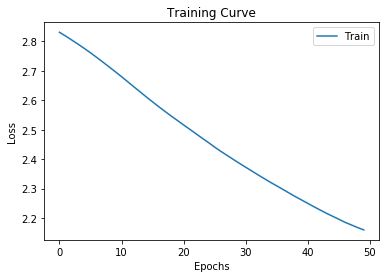

>> Training complete. Took 862.006 seconds
>> Training model for 100 epoch(s).
Epoch  1: train loss = 2.8309 time = 17.428 seconds
Epoch  2: train loss = 2.8180 time = 17.432 seconds
Epoch  3: train loss = 2.8043 time = 17.437 seconds
Epoch  4: train loss = 2.7904 time = 17.442 seconds
Epoch  5: train loss = 2.7761 time = 17.468 seconds
Epoch  6: train loss = 2.7612 time = 17.430 seconds
Epoch  7: train loss = 2.7455 time = 17.431 seconds
Epoch  8: train loss = 2.7295 time = 17.448 seconds
Epoch  9: train loss = 2.7133 time = 17.455 seconds
Epoch 10: train loss = 2.6968 time = 17.468 seconds
Epoch 11: train loss = 2.6801 time = 17.456 seconds
Epoch 12: train loss = 2.6628 time = 17.484 seconds
Epoch 13: train loss = 2.6454 time = 17.475 seconds
Epoch 14: train loss = 2.6284 time = 17.472 seconds
Epoch 15: train loss = 2.6111 time = 17.459 seconds
Epoch 16: train loss = 2.5945 time = 17.460 seconds
Epoch 17: train loss = 2.5780 time = 17.450 seconds
Epoch 18: train loss = 2.5621 time = 

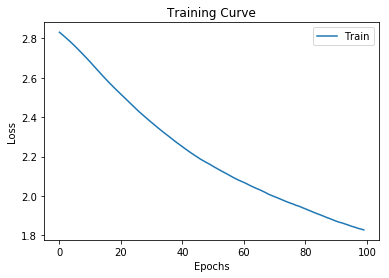

>> Training complete. Took 1746.351 seconds


In [14]:
model_50 = LSTM1(2205, 4410)
train(model_50, train_data, 50, 32, 1e-2)

model_100 = LSTM1(2205, 4410)
train(model_100, train_data, 100, 32, 1e-2)


In [0]:
class LSTM2(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers=2):
        super(LSTM2, self).__init__()
        self.rnn = nn.LSTM(emb_size, hidden_size, num_layers=n_layers, batch_first=True).cuda()
        self.decoder = nn.Linear(hidden_size, emb_size).cuda()

    def forward(self, x, hidden = None):
        out, hidden = self.rnn(x)
        out = self.decoder(out)
        return out, hidden

In [0]:
model2 = LSTM2(2205, 4410)
train(model2, train_data, 50, 32, 1e-3)

>> Training model for 50 epoch(s).
Epoch  1: train loss = 4.1982 time = 33.673 seconds
Epoch  2: train loss = 4.1958 time = 33.658 seconds
Epoch  3: train loss = 4.1929 time = 33.661 seconds
Epoch  4: train loss = 4.1896 time = 33.660 seconds
Epoch  5: train loss = 4.1823 time = 33.647 seconds
Epoch  6: train loss = 4.1815 time = 33.656 seconds
Epoch  7: train loss = 4.1768 time = 33.662 seconds
Epoch  8: train loss = 4.1726 time = 33.661 seconds
Epoch  9: train loss = 4.1658 time = 33.657 seconds
Epoch 10: train loss = 4.1551 time = 33.659 seconds
Epoch 11: train loss = 4.1458 time = 33.664 seconds
Epoch 12: train loss = 4.1351 time = 33.655 seconds
Epoch 13: train loss = 4.1423 time = 33.653 seconds
Epoch 14: train loss = 4.1157 time = 33.658 seconds
Epoch 15: train loss = 4.1000 time = 33.660 seconds
Epoch 16: train loss = 4.0995 time = 33.657 seconds
Epoch 17: train loss = 4.0832 time = 33.651 seconds
Epoch 18: train loss = 4.0622 time = 33.654 seconds
Epoch 19: train loss = 4.0431

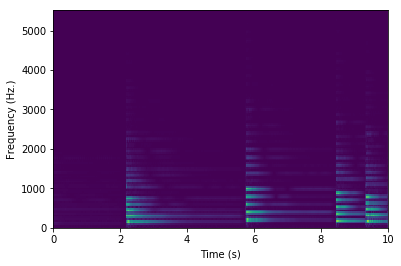

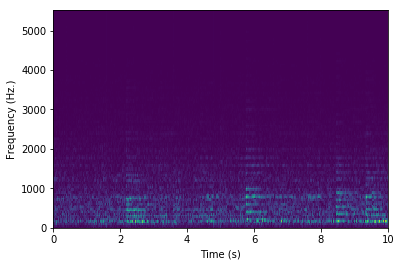

In [0]:
from matplotlib import pyplot as plt

mel, acc = train_data[9]
gen_acc, _ = model(mel)

acc = np.array(acc.flatten().cpu())
gen_acc = np.array(gen_acc.detach().flatten().cpu())

f, t, Zxx = signal.stft(acc, 11025)
plt.pcolormesh(t, f, np.abs(Zxx))
plt.ylabel('Frequency (Hz.)')
plt.xlabel('Time (s)')
plt.savefig('test1.pdf')
plt.show()

f, t, Zxx = signal.stft(gen_acc, 11025)
plt.pcolormesh(t, f, np.abs(Zxx))
plt.ylabel('Frequency (Hz.)')
plt.xlabel('Time (s)')
plt.savefig('test2.pdf')
plt.show()

In [0]:
for i in range(0, len(train_data)):
    gen_acc , _ = model50(train_data[i][0])
    gen_acc = gen_acc.detach().cpu()

    output = np.array(gen_acc.reshape((1, -1)), dtype = np.int16)
    output.tofile(drive_path + data_out_path + "gen_acc"+str(i)+ ".bin")

    true_acc =  np.array(train_data[i][1].unsqueeze(0).reshape((1, -1)).cpu(), dtype = np.int16)
    true_acc.tofile(drive_path + data_out_path + "true_acc" + str(i) + ".bin")

In [0]:
data_out_path = '/data/audio/generated/'
# train data
for i in range(0, len(train_data)):
    gen_acc , _ = model(train_data[i][0])
    gen_acc = gen_acc.detach().cpu()

    output = np.array(gen_acc.reshape((1, -1)), dtype = np.int16)
    output.tofile(drive_path + data_out_path + "gen_acc"+str(i)+ ".bin")

    true_acc =  np.array(train_data[i][1].unsqueeze(0).reshape((1, -1)).cpu(), dtype = np.int16)
    true_acc.tofile(drive_path + data_out_path + "true_acc" + str(i) + ".bin")

In [0]:
# test data
for i in range(0, len(test_data)):
    gen_acc , _ = model(test_data[i][0])
    gen_acc = gen_acc.detach().cpu()

    output = np.array(gen_acc.reshape((1, -1)), dtype = np.int16)
    output.tofile(drive_path + data_out_path + "gen_acc"+str(i)+ ".bin")

    true_acc =  np.array(test_data[i][1].unsqueeze(0).reshape((1, -1)).cpu(), dtype = np.int16)
    true_acc.tofile(drive_path + data_out_path + "true_acc" + str(i) + ".bin")